In [2]:
from PIL import Image

im = Image.open(r"./group15/train/26.png")
im.show()

In [3]:
px = im.load()


In [4]:
# getting consecuitve pathces of 7*7 from im
def get_patches(im):
    px = im.load()
    patches = []
    for i in range(0,  im.size[0] - 7):
        for j in range(0, im.size[1] - 7):
            patch = []
            for k in range(i, i + 7):
                for l in range(j, j + 7):
                    patch.append(px[k, l])
            patches.append(patch)
    return patches

In [5]:
import numpy as np
pathces = np.array(get_patches(im))
print(pathces.shape)

(255025, 49)


In [6]:
# find mean and covariace of each patch
def mean_cov(patches):
    mean = np.mean(patches, axis=1)
    var = np.var(patches, axis=1)
    return mean, var
mean, var = mean_cov(pathces)


In [7]:
print(mean.shape)
print(var.shape)
# making data proints from mean and var
data = []
for i in range(len(mean)):
    data.append([mean[i], var[i]])
data = np.array(data)
print(data.shape)

(255025,)
(255025,)
(255025, 2)


(49,)


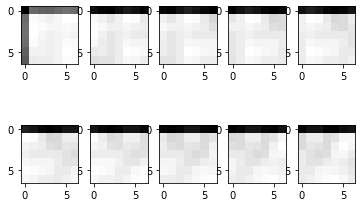

In [8]:
print(pathces[0].shape)
# print the patches
import matplotlib.pyplot as plt
for i in range(0, 10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(pathces[i].reshape(7, 7), cmap='gray')
plt.show()


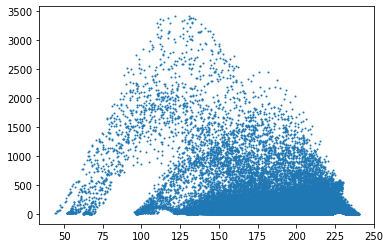

c:\Users\Vaibhav\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


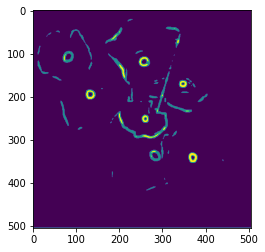

In [9]:
# plot the mean and covariance
import matplotlib.pyplot as plt
plt.scatter(mean, var, s=1)
plt.show()

# using k-means to cluster the patches
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
#now show the image
labels = kmeans.labels_
#plot the image
import matplotlib.pyplot as plt
# plt.imshow(labels.reshape(im.size[0] - 7, im.size[1] - 7))
# rotate the image by 180 degree
plt.imshow(labels.reshape(im.size[0] - 7, im.size[1] - 7)[::-1])
plt.show()

print(labels)

In [10]:
#k menas using mahalanobis distance
from scipy.spatial.distance import mahalanobis
def mahalanobis_distance(x, y, cov):
    return mahalanobis(x, y, cov)
# print(mahalanobis_distance([1, 2], [1, 2], [[1, 0], [0, 1]]))

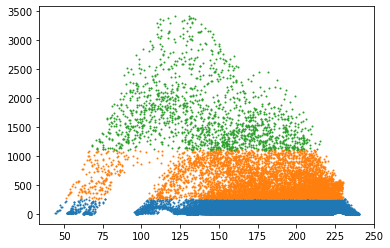

In [11]:
for j in range(3):
    plt.scatter(mean[labels == j], var[labels == j], s=1)

In [ ]:
# # read from all the files 23.png to 122.png
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from PIL import Image
# path = "./group15/train/"
# files = os.listdir(path)
# # only .png files
# files = [file for file in files if file.endswith('.png')]
# # sort the files
# files.sort()
# print(files)
# patches = []
# for file in files:
#     im = Image.open(path + file)
#     patches.append(get_patches(im))
# patches = np.array(patches)
# print(patches.shape)


In [ ]:
# for patch in patches:
#     mean, var = mean_cov(patch)
#     plt.scatter(mean, var, s=0.1)
# plt.show()

In [ ]:
# how many data points
# print(patches.shape[0] * patches.shape[1])

In [ ]:
import numpy as np
import random
class clusterPoint:
    def __init__(self, point, cluster):
        self.point = point
        self.cluster = cluster
class Cluster_representation:
    def __init__(self,mean,covariance,weight):
        self.mean=mean
        self.covariance=covariance
        self.weight=weight
        
class K_Mahalanobis:
            
    def dissimilarity(self, point1, which_cluster):
        # print(self.clusters[which_cluster].mean)
        diff = np.array(point1) - np.array(self.clusters[which_cluster].mean)
        return np.sqrt(np.dot(diff.T, np.dot(np.linalg.inv(self.clusters[which_cluster].covariance), diff)))
    
    def __init__(self, k):
        self.k = k
        self.clusters = [Cluster_representation(None,None,None) for i in range(k)]
        
    def distortion(self, data):
        sum = 0
        for point in data:
            sum += self.dissimilarity(point, point.cluster)
        return sum
    
    def updateK(self):
        self.k+=1
        
    # data here is a list of feature vectors return the cluster points
    def fit(self,data):
        # initilizing cluster centers
        centers=set()
        while len(centers)<self.k:
            centers.add(random.randint(0,len(data)-1))
        centers=list(centers)
        
        self.clusters = [Cluster_representation(data[i],np.eye(data[0].shape[0]),1/self.k) for i in centers]

        cluster_points = []
        for points in data:
            cluster_points.append(clusterPoint(points, 0))
            
        iterations=0
        while True:
            # assign each feature vector to a cluster(we have hard clustering in K-means)
            new_clusters = [[] for i in range(self.k)]
            for point in cluster_points:
                which_cluster = 0
                for i in range(self.k):
                    if self.dissimilarity(point.point, i) < self.dissimilarity(point.point, which_cluster):
                        which_cluster = i
                new_clusters[which_cluster].append(point)
                point.cluster = which_cluster
                
            # update cluster parameters
            new_means = []
            for i in range(self.k):
                new_means.append(np.mean([point.point for point in new_clusters[i]], axis=0))
            new_covariances = []
            for i in range(self.k):
                new_covariances.append(np.cov([point.point for point in new_clusters[i]], rowvar=False))
            
            new_weights = []
            for i in range(self.k):
                new_weights.append(len(new_clusters[i]) / len(cluster_points))
            
            prev_centers=[cluster.mean for cluster in self.clusters]
            self.clusters = [Cluster_representation(new_means[i],new_covariances[i],new_weights[i]) for i in range(self.k)]
                
            converged=True
            for i in range(self.k):
                if not np.array_equal(prev_centers[i], self.clusters[i].mean):
                   converged = False
            
            if(converged):
                break
            
            iterations+=1
            
            print("iteration",iterations,"distortion",self.distortion(cluster_points) )
            
            if(iterations>5):
                break
        
        return cluster_points,iterations


class K_Means(K_Mahalanobis):
    def __init__(self, k):
        super().__init__(k)
               
    def dissimilarity(self, point1, which_cluster):
        return np.sqrt(np.sum(np.square(np.array(point1) - np.array(self.clusters[which_cluster].mean))))

In [ ]:
model = K_Means(3)
model.fit(data)

TypeError: unsupported operand type(s) for -: 'clusterPoint' and 'float'